IMPORTING DATA FROM KAGGLE

In [ ]:
!mkdir -p ~/.kaggle
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images --force

 99% 118M/119M [00:06<00:00, 24.9MB/s]
100% 119M/119M [00:06<00:00, 19.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-ctscan-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

INSTALLING DEPENDENCIES


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2
from keras.applications import resnet
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
s=256
METRICS = [
      BinaryAccuracy(name='acc'),
      Precision(name='precision'),
      Recall(name='recall'),  
      AUC(name='auc')
]

In [ ]:
main_dir="/content/Data"
train_data=ImageDataGenerator(rescale=1./255)
test_data=ImageDataGenerator(rescale=1./255)
valid_data=ImageDataGenerator(rescale=1./255)

train_dir=os.path.join(main_dir ,'train')
train_set = train_data.flow_from_directory(train_dir,target_size=(s,s),batch_size=32,class_mode='categorical')

test_dir=os.path.join(main_dir ,'test')
test_set = test_data.flow_from_directory(test_dir,target_size=(s,s),batch_size=32,class_mode='categorical')

valid_dir=os.path.join(main_dir ,'valid')
valid_set = test_data.flow_from_directory(valid_dir,target_size=(s,s),batch_size=32,class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
class_names=list(test_set.class_indices.keys())
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

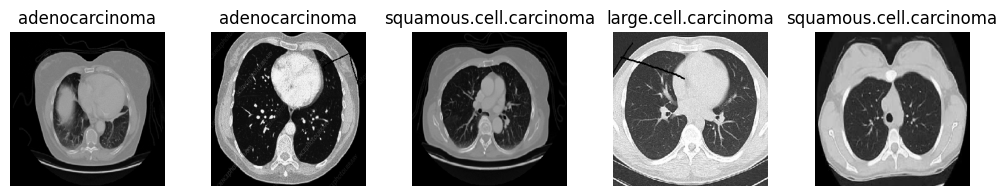

In [ ]:
class_names=list(test_set.class_indices.keys())
plt.figure(figsize=(10, 10))
for _ in range(5):
    img, label = test_set.next()
    plt.subplot(1, 5, _+1)
    plt.tight_layout()        
    plt.axis('off')
    plt.imshow(img[0], cmap='gray') 
    plt.title(class_names[np.argmax(label[_])])

CNN MODEL

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(s,s,3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.Dropout((0.4)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_cnn.add(layers.Dropout((0.4)))
model_cnn.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_cnn.add(layers.Dense(4, activation='softmax'))
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)      

In [ ]:
from keras.callbacks import EarlyStopping
model_cnn.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=METRICS)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

cnn = model_cnn.fit(
         train_set,
         validation_data=valid_set,
         batch_size=32,
         epochs=30,
         callbacks=[early_stop])

Epoch 1/30
20/20 [==============================] - 9s 359ms/step - loss: 1.4029 - acc: 0.7402 - precision: 0.2931 - recall: 0.0277 - auc: 0.5690 - val_loss: 1.4224 - val_acc: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5199
Epoch 2/30
20/20 [==============================] - 7s 319ms/step - loss: 1.2884 - acc: 0.7557 - precision: 0.5972 - recall: 0.0701 - auc: 0.6585 - val_loss: 1.3206 - val_acc: 0.7778 - val_precision: 1.0000 - val_recall: 0.1111 - val_auc: 0.6370
Epoch 3/30
20/20 [==============================] - 7s 314ms/step - loss: 1.1500 - acc: 0.7773 - precision: 0.6588 - recall: 0.2268 - auc: 0.7701 - val_loss: 2.3089 - val_acc: 0.7465 - val_precision: 0.4898 - val_recall: 0.3333 - val_auc: 0.6417
Epoch 4/30
20/20 [==============================] - 9s 428ms/step - loss: 0.9838 - acc: 0.8083 - precision: 0.6877 - recall: 0.4274 - auc: 0.8429 - val_loss: 0.9070 - val_acc: 0.8021 - val_precision: 0.6829 - val_recall: 0.3889 - val_auc: 0.8475
Epoch 5/

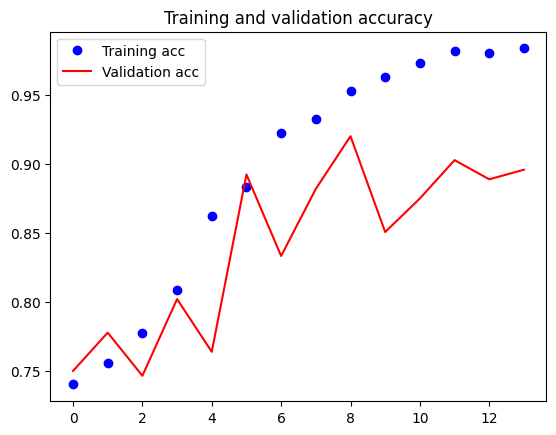

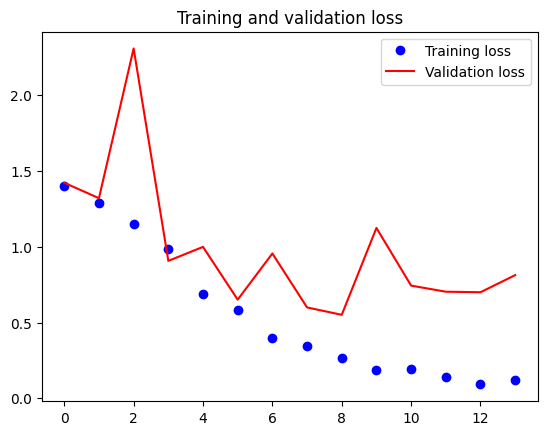

In [ ]:
acc = cnn.history['acc']
val_acc = cnn.history['val_acc']
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

iters = range(len(acc))

plt.plot(iters, acc, 'bo', label='Training acc')
plt.plot(iters, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(iters, loss, 'bo', label='Training loss')
plt.plot(iters, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = model_cnn.evaluate(valid_set)
accuracy_cnn=pred[1]

3/3 [==============================] - 0s 93ms/step - loss: 0.8129 - acc: 0.8958 - precision: 0.8000 - recall: 0.7778 - auc: 0.9335


RESNET MODEL


In [ ]:
input_shape = (s,s,3)

resent_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=input_shape)

for layer in resent_model.layers:
    layer.trainable = False
    
model_res = models.Sequential()
model_res.add(resent_model)
model_res.add(layers.Flatten())
model_res.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_res.add(layers.Dropout((0.2)))
model_res.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_res.add(layers.Dense(4, activation='softmax'))
model_res.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=METRICS)

model_res.summary()

94668760/94668760 [==============================] - 6s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 Layer_1 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 Layer_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=25)

res = model_res.fit(train_set,
                validation_data = valid_set,
                epochs = 100,
                steps_per_epoch=len(train_set),
                validation_steps=len(valid_set),
                callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 13s 318ms/step - loss: 16.1644 - acc: 0.7511 - precision: 0.5022 - recall: 0.4934 - auc: 0.6986 - val_loss: 3.9866 - val_acc: 0.8229 - val_precision: 0.6479 - val_recall: 0.6389 - val_auc: 0.7994
Epoch 2/100
20/20 [==============================] - 4s 200ms/step - loss: 1.8213 - acc: 0.9286 - precision: 0.8578 - recall: 0.8564 - auc: 0.9322 - val_loss: 1.8649 - val_acc: 0.9167 - val_precision: 0.8333 - val_recall: 0.8333 - val_auc: 0.9023
Epoch 3/100
20/20 [==============================] - 5s 223ms/step - loss: 0.9211 - acc: 0.9543 - precision: 0.9086 - recall: 0.9086 - auc: 0.9616 - val_loss: 1.7290 - val_acc: 0.8854 - val_precision: 0.7746 - val_recall: 0.7639 - val_auc: 0.8915
Epoch 4/100
20/20 [==============================] - 4s 215ms/step - loss: 0.7632 - acc: 0.9604 - precision: 0.9216 - recall: 0.9201 - auc: 0.9644 - val_loss: 3.0555 - val_acc: 0.8542 - val_precision: 0.7083 - val_recall: 0.7083 - val_auc: 0.8404
Epoch 5/10

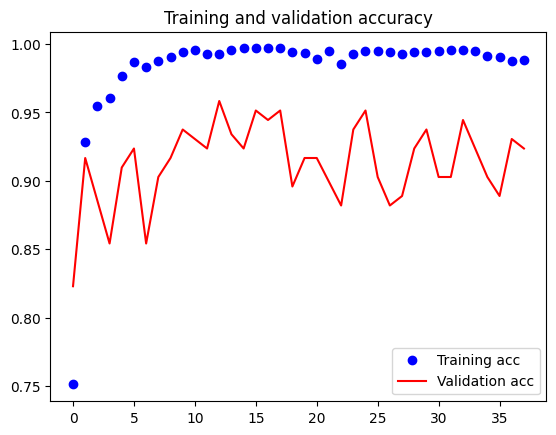

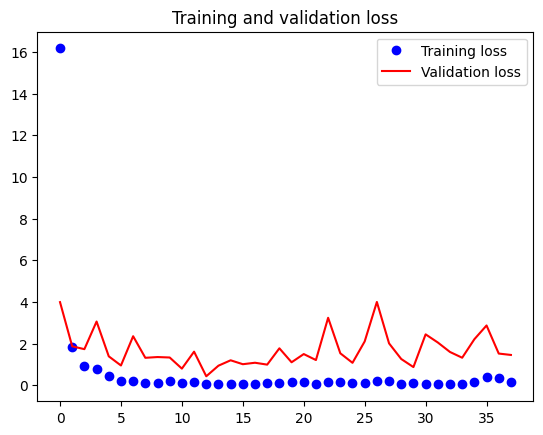

In [ ]:
acc = res.history['acc']
val_acc = res.history['val_acc']
loss = res.history['loss']
val_loss = res.history['val_loss']

iters = range(len(acc))

plt.plot(iters, acc, 'bo', label='Training acc')
plt.plot(iters, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(iters, loss, 'bo', label='Training loss')
plt.plot(iters, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict = model_res.evaluate(valid_set)
accuracy_resnet=predict[1]

3/3 [==============================] - 0s 87ms/step - loss: 1.4510 - acc: 0.9236 - precision: 0.8472 - recall: 0.8472 - auc: 0.9235


VGG 16 MODEL


In [ ]:
model_vgg16 = VGG16(weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model_vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in resent_model.layers:
    layer.trainable = False
    
model_vgg16 = models.Sequential()
model_vgg16.add(resent_model)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_vgg16.add(layers.Dropout((0.2)))
model_vgg16.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_vgg16.add(layers.Dense(4, activation='softmax'))
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=METRICS)

model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 Layer_1 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 Layer_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 57,152,900
Trainable params: 33,588,100


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=25)

vgg16 = model_vgg16.fit(train_set,
                validation_data = valid_set,
                epochs = 100,
                steps_per_epoch=len(train_set),
                validation_steps=len(valid_set),
                callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 9s 265ms/step - loss: 15.2827 - acc: 0.7704 - precision: 0.5414 - recall: 0.5343 - auc: 0.7187 - val_loss: 6.1422 - val_acc: 0.7986 - val_precision: 0.5972 - val_recall: 0.5972 - val_auc: 0.7597
Epoch 2/100
20/20 [==============================] - 4s 190ms/step - loss: 2.6236 - acc: 0.8801 - precision: 0.7602 - recall: 0.7602 - auc: 0.8760 - val_loss: 1.0559 - val_acc: 0.9097 - val_precision: 0.8194 - val_recall: 0.8194 - val_auc: 0.9260
Epoch 3/100
20/20 [==============================] - 4s 211ms/step - loss: 1.0680 - acc: 0.9339 - precision: 0.8691 - recall: 0.8662 - auc: 0.9479 - val_loss: 0.8376 - val_acc: 0.9097 - val_precision: 0.8194 - val_recall: 0.8194 - val_auc: 0.9514
Epoch 4/100
20/20 [==============================] - 4s 202ms/step - loss: 0.4308 - acc: 0.9698 - precision: 0.9396 - recall: 0.9396 - auc: 0.9759 - val_loss: 1.1966 - val_acc: 0.8958 - val_precision: 0.7917 - val_recall: 0.7917 - val_auc: 0.9196
Epoch 5/100

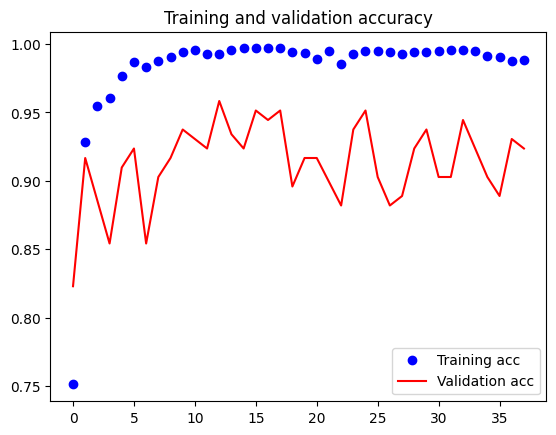

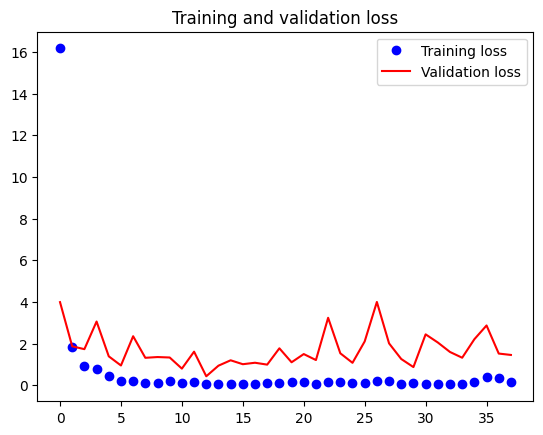

In [ ]:
acc = res.history['acc']
val_acc = res.history['val_acc']
loss = res.history['loss']
val_loss = res.history['val_loss']

iters = range(len(acc))

plt.plot(iters, acc, 'bo', label='Training acc')
plt.plot(iters, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(iters, loss, 'bo', label='Training loss')
plt.plot(iters, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predict = model_vgg16.evaluate(valid_set)
accuracy_vgg16=predict[1]

3/3 [==============================] - 0s 98ms/step - loss: 1.0688 - acc: 0.9514 - precision: 0.9028 - recall: 0.9028 - auc: 0.9435


INCEPTION MODEL


In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
model_incep = models.Sequential()
model_incep.add(resent_model)
model_incep.add(layers.Flatten())
model_incep.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_incep.add(layers.Dropout((0.2)))
model_incep.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_incep.add(layers.Dense(4, activation='softmax'))
model_incep.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=METRICS)

model_incep.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 Layer_1 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 Layer_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 57,152,900
Trainable params: 33,588,100


In [ ]:

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=25)

incep = model_incep.fit(train_set,
                validation_data = valid_set,
                epochs = 100,
                steps_per_epoch=len(train_set),
                validation_steps=len(valid_set),
                callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 10s 281ms/step - loss: 11.6222 - acc: 0.7693 - precision: 0.5389 - recall: 0.5358 - auc: 0.7235 - val_loss: 1.6116 - val_acc: 0.9097 - val_precision: 0.8194 - val_recall: 0.8194 - val_auc: 0.9134
Epoch 2/100
20/20 [==============================] - 4s 199ms/step - loss: 2.0585 - acc: 0.8911 - precision: 0.7827 - recall: 0.7814 - auc: 0.9044 - val_loss: 1.0647 - val_acc: 0.8750 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.9441
Epoch 3/100
20/20 [==============================] - 4s 207ms/step - loss: 0.6364 - acc: 0.9478 - precision: 0.8956 - recall: 0.8956 - auc: 0.9686 - val_loss: 1.5095 - val_acc: 0.9167 - val_precision: 0.8333 - val_recall: 0.8333 - val_auc: 0.9209
Epoch 4/100
20/20 [==============================] - 4s 204ms/step - loss: 0.5567 - acc: 0.9641 - precision: 0.9282 - recall: 0.9282 - auc: 0.9732 - val_loss: 1.7501 - val_acc: 0.8958 - val_precision: 0.7917 - val_recall: 0.7917 - val_auc: 0.9018
Epoch 5/10

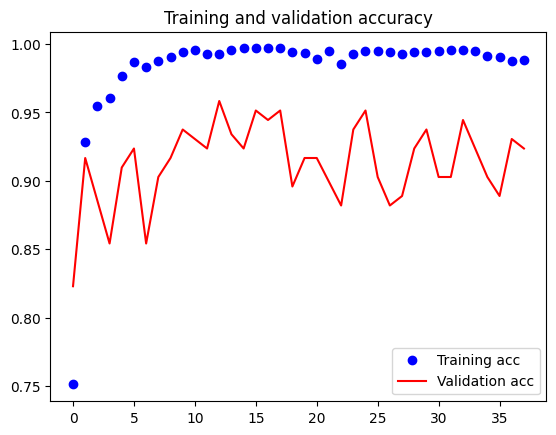

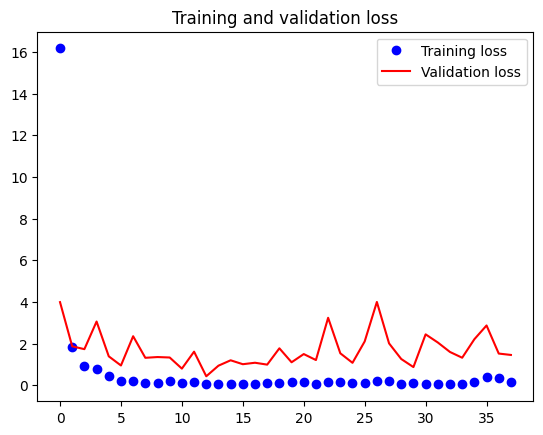

In [ ]:
acc = res.history['acc']
val_acc = res.history['val_acc']
loss = res.history['loss']
val_loss = res.history['val_loss']

iters = range(len(acc))

plt.plot(iters, acc, 'bo', label='Training acc')
plt.plot(iters, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(iters, loss, 'bo', label='Training loss')
plt.plot(iters, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
predict = model_incep.evaluate(valid_set)
accuracy_incept=predict[1]

3/3 [==============================] - 1s 101ms/step - loss: 2.2424 - acc: 0.9028 - precision: 0.8056 - recall: 0.8056 - auc: 0.9106


STORING THE BEST MODEL


In [ ]:
model_vgg16.save('/content/Model/VGG16')

In [ ]:
from google.colab import files

In [ ]:
import shutil
import zipfile

def create_zip_folder(folder_path, zip_filename):
    shutil.make_archive(zip_filename, 'zip', folder_path)
    print(f"Zip folder '{zip_filename}.zip' created successfully!")

# Example usage
folder_path = "/content/Model"
zip_filename = "/content/Model.zip"

create_zip_folder(folder_path, zip_filename)


Zip folder '/content/Model.zip.zip' created successfully!


PLOTING THE GRAPH

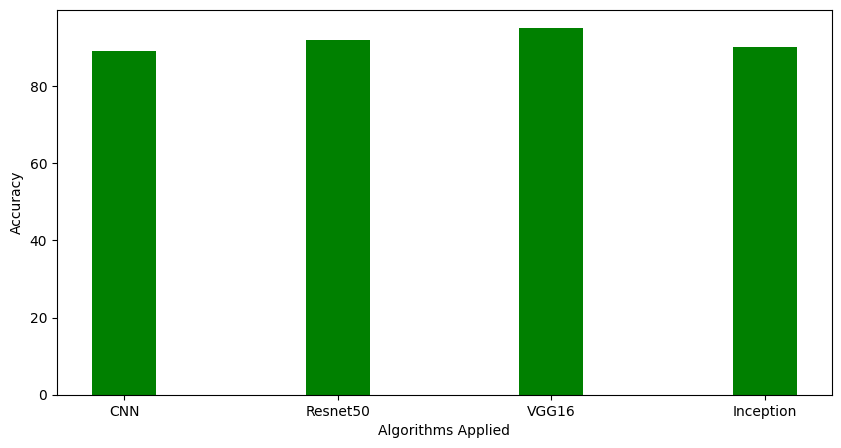

0.8958333134651184 0.9236111044883728 0.9513888955116272 0.9027777910232544


In [ ]:
algos = ['CNN',  'Resnet50', 'VGG16' , 'Inception']
accuracy = [accuracy_cnn, accuracy_resnet, accuracy_vgg16, accuracy_incept]
accuracy = np.floor([i * 100 for i in accuracy])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(algos, accuracy, color ='green', width = 0.3)
 
plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()
print(accuracy_cnn, accuracy_resnet, accuracy_vgg16, accuracy_incept)

In [ ]:
import keras.utils as image

def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    img = image.load_img(path, target_size=(s,s))
    norm_img = image.img_to_array(img)/255
    input_arr_img = np.array([norm_img])
    pred = np.argmax(_model.predict(input_arr_img))
    print(classes_dir[pred])



In [ ]:
path = "/content/Data/test/large.cell.carcinoma/000174.png"
chestScanPrediction(path,model_res)

1/1 [==============================] - 1s 1s/step
Large cell carcinoma


In [ ]:
path = "/content/Data/test/large.cell.carcinoma/000174.png"
chestScanPrediction(path,model_vgg16)

1/1 [==============================] - 1s 786ms/step
Large cell carcinoma


In [ ]:
path = "/content/Data/test/large.cell.carcinoma/000174.png"
chestScanPrediction(path,model_cnn)

1/1 [==============================] - 0s 206ms/step
Adenocarcinoma
